## Spark cluster intro Air quality examples

### Initialization
Create and attach cluster created in EMR. 

The important configuration options:
 - Amazon EMR version: emr-7.1.0
 - Installed applications: JupyterHub 1.5.0
 - Logs in Amazon S3: disabled
 - Service role for Amazon EMR: EMR_DefaultRole 
 - EC2 instance profile: EMR_EC2_DefaultRole
 - EC2 security groups (firewall): open ports 9443, 18080
 
Login: jovyan, password: jupyter

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
spark = SparkSession.builder.getOrCreate()

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1729766287750_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1729766287750_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1729766287750_0003,pyspark,idle,Link,Link,None,✔


In [3]:
# run once per session to install additional packages
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1729766287750_0003/container_1729766287750_0003_01_000001/tmp/spark-3ee247ed-438c-482e-acfb-66ac3fc79894
    Can't uninstall 'python-dateutil'. No files were found to uninstall.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.


In [4]:
from pyspark.sql.functions import col, mean
import matplotlib.pyplot as plt
import pandas as pd
import time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Reading data from AWS S3

Now we can read a small sample of data:

In [5]:
start = time.time()

smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=10*/year=2022/month=05/*.csv.gz")
    #.load("s3a://openaq-data-archive/records/csv.gz/locationid=2178/year=2022/month=05/location-2178-20220503.csv.gz")\

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

336.9859447479248

In [6]:
# Further queries on smog_df will run much faster when we cache this data set in memory
smog_df.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[location_id: string, sensors_id: string, location: string, datetime: string, lat: string, lon: string, parameter: string, units: string, value: string]

In [7]:
start = time.time()
smog_df.count()
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

214.7749364376068

In [8]:
smog_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location_id: string (nullable = true)
 |-- sensors_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: string (nullable = true)

In [9]:
smog_df = smog_df.withColumn("value", smog_df.value.cast('double'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Simple queries

In [10]:
smog_df.limit(10).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+
|location_id|sensors_id|            location|            datetime|      lat|      lon|parameter|units|  value|
+-----------+----------+--------------------+--------------------+---------+---------+---------+-----+-------+
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T01:00:...|50.349608|18.236575|     pm10|µg/m³|  15.62|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T02:00:...|50.349608|18.236575|     pm10|µg/m³|13.6041|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T03:00:...|50.349608|18.236575|     pm10|µg/m³|13.7349|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T04:00:...|50.349608|18.236575|     pm10|µg/m³|15.1872|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T05:00:...|50.349608|18.236575|     pm10|µg/m³|13.0822|
|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T06:00:...|50.349608|18.236575|     pm10|µg/m³|14.0526|
|

In [11]:
smog_df.select('parameter').distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|parameter|
+---------+
|       co|
|     pm10|
|      so2|
|      no2|
|       bc|
|     pm25|
|       o3|
+---------+

In [12]:
from pyspark.sql.functions import col, asc, desc, max

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Some more interesting statistics

In [13]:
start = time.time()
max_pm10 = smog_df.filter(col('parameter')=='pm10')\
            .filter(col('value')>0.0)\
            .groupby('location').agg(max('value').alias('max_pm10'))\
            .sort(desc('max_pm10'))

max_pm10.limit(100).show(truncate=False)
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------+-----------+
|location                                        |max_pm10   |
+------------------------------------------------+-----------+
|Ballygunge, Kolkata - WBPCB-10918               |9999.9     |
|Govt. High School Shikarpur, Patna - BSPCB-10630|5631.1     |
|Sanjay Nagar, Ghaziabad - UPPCB-10919           |3490.0     |
|New Industrial Town, Faridabad - HSPCB-10920    |2217.0     |
|Mundka, Delhi - DPCC-10486                      |1787.0     |
|Sector 30, Faridabad - HSPCB-10820              |1309.16    |
|Nedre Langgate-10492                            |1187.386375|
|Mini Secretariat, Charkhi Dadri - HSPCB-10725   |1186.4     |
|Sector 11, Faridabad - HSPCB-10908              |1090.9     |
|Rajbansi Nagar, Patna - BSPCB-10599             |1003.2     |
|Sector-51, Gurugram - HSPCB-10825               |999.99     |
|Rishi Nagar, Kaithal - HSPCB-10905              |999.99     |
|Murthal, Sonipat - HSPCB-10906                  |999.9

In [14]:
smog_df.filter(col('location').contains('Krak')).select('location').distinct().show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------+
|location                        |
+--------------------------------+
|Kraków, ul. Bulwarowa-10516     |
|Kraków, Aleja Krasińskiego-10752|
+--------------------------------+

In [15]:
max_pm10.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location: string (nullable = true)
 |-- max_pm10: double (nullable = true)

In [16]:
plt.figure()
max_pm10.limit(10).toPandas().plot.barh(x='location')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<Axes: ylabel='location'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

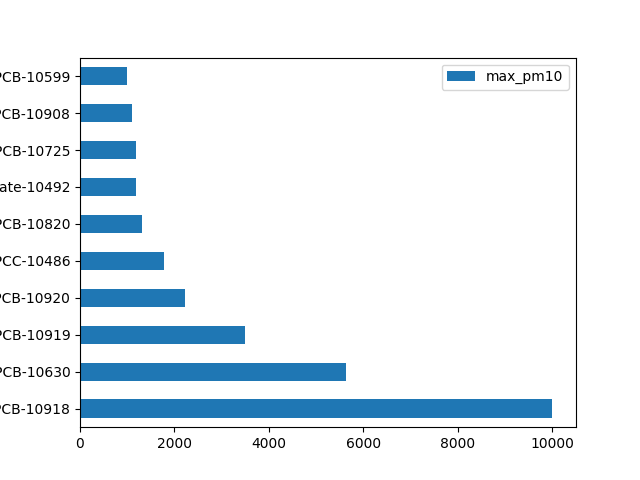

In [17]:
# On EMR we need this magic to show the plot
%matplot plt